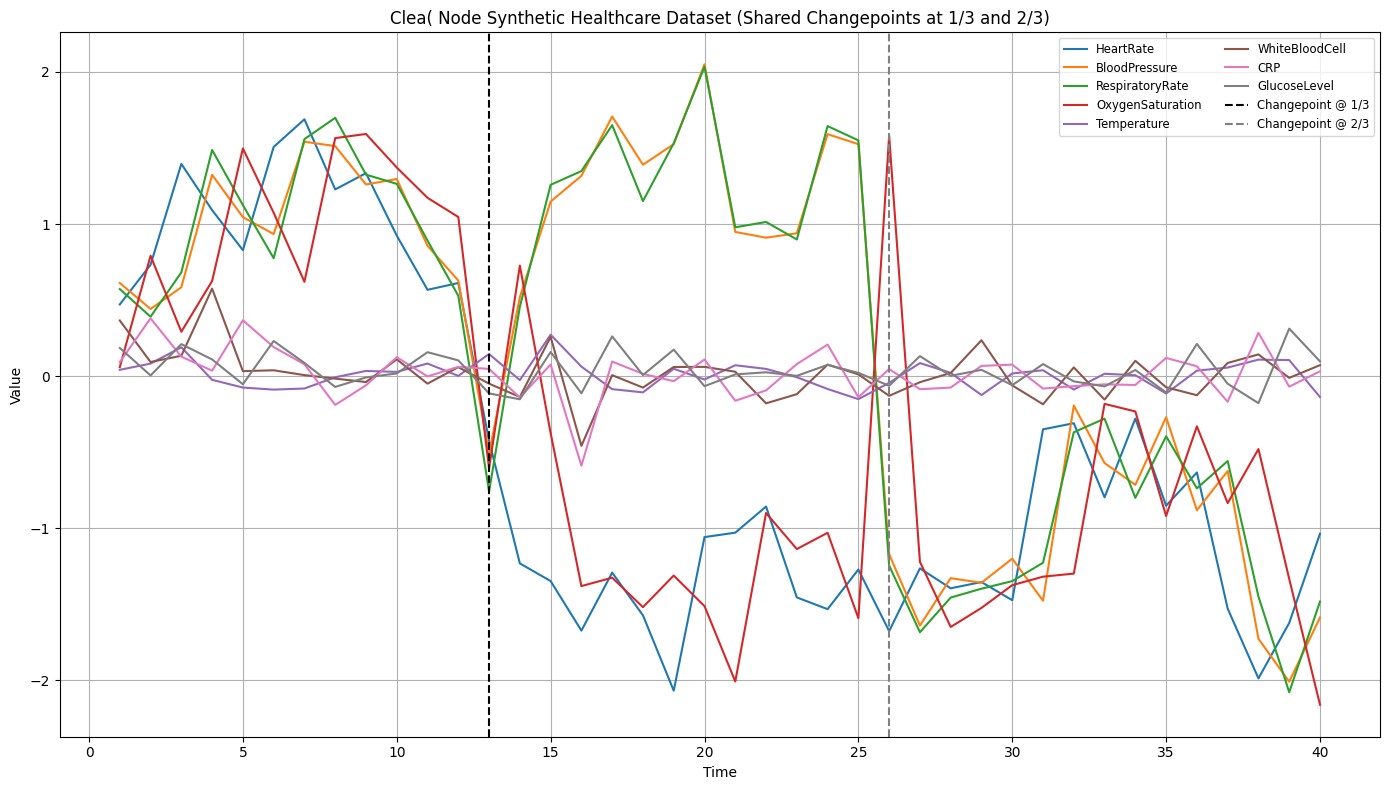

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_8_node_dataset(m=40, epsilon=0.5, noise_scale=0.1, seed=42):
    """  
    Parameters:
    - m (int): number of time steps
    - epsilon (float): AR(1) noise strength for HeartRate
    - noise_scale (float): standard deviation for Gaussian noise in all other nodes
    - seed (int): random seed for reproducibility
    
    Returns:
    - df (DataFrame): time series data for all 8 nodes
    - beta (ndarray): (n_vars x m) matrix of beta values over time
    - cp1, cp2 (int): changepoint indices (1/3 and 2/3 of time)
    """
    np.random.seed(seed)
    n_vars = 8  # Number of variables/nodes
    X = np.zeros((n_vars, m + 1))  # Time series data storage (with t=0 included)
    phi = np.random.normal(0, 1, (n_vars, m + 1))  # Independent Gaussian noise

    # Shared changepoints for all variables at 1/3 and 2/3 of timeline
    cp1 = m // 3
    cp2 = 2 * m // 3

    # Initialize beta matrix: each variable has beta = 1, -1, 1 across 3 segments
    beta = np.ones((n_vars, m + 1))
    for i in range(n_vars):
        beta[i, cp1:cp2] = -1  # middle segment has reversed influence

    # Initial conditions for HeartRate and Temperature
    X[0, 0] = np.random.normal(0, 1)   # HeartRate (autoregressive root)
    X[4, 0] = np.random.normal(0, 0.5) # Temperature (noise-only variable)

    # HeartRate (node 0): AR(1) process
    for t in range(m):
        X[0, t + 1] = np.sqrt(1 - epsilon**2) * X[0, t] + epsilon * phi[0, t + 1]

    # Nodes 1–7: linearly dependent with noise
    for t in range(m):
        # Node 1: BloodPressure ← HeartRate
        X[1, t + 1] = beta[1, t + 1] * X[0, t] + noise_scale * phi[1, t + 1]
        
        # Node 2: RespiratoryRate ← HeartRate
        X[2, t + 1] = beta[2, t + 1] * X[0, t] + noise_scale * phi[2, t + 1]
        
        # Node 3: OxygenSaturation ← RespiratoryRate
        X[3, t + 1] = beta[3, t + 1] * X[2, t] + noise_scale * phi[3, t + 1]
        
        # Node 4: Temperature ← noise only
        X[4, t + 1] = noise_scale * phi[4, t + 1]
        
        # Node 5: WhiteBloodCell ← Temperature
        X[5, t + 1] = beta[5, t + 1] * X[4, t] + noise_scale * phi[5, t + 1]
        
        # Node 6: CRP ← avg(Temperature, WBC)
        X[6, t + 1] = beta[6, t + 1] * (0.5 * X[4, t] + 0.5 * X[5, t]) + noise_scale * phi[6, t + 1]
        
        # Node 7: GlucoseLevel ← avg(Temperature, CRP)
        X[7, t + 1] = beta[7, t + 1] * (0.5 * X[4, t] + 0.5 * X[6, t]) + noise_scale * phi[7, t + 1]

    # Variable names (healthcare-inspired)
    variables = [
        "HeartRate", "BloodPressure", "RespiratoryRate", "OxygenSaturation",
        "Temperature", "WhiteBloodCell", "CRP", "GlucoseLevel"
    ]

    # Create DataFrame: drop initial t=0, add time column
    df = pd.DataFrame(X[:, 1:].T, columns=variables)
    df["Time"] = np.arange(1, m + 1)

    return df, beta[:, 1:], cp1, cp2 

# === Generate dataset and plot ===
df, beta_matrix, cp1, cp2 = generate_8_node_dataset()

# Plot time series for all variables
plt.figure(figsize=(14, 8))
for col in df.columns[:-1]:  # Exclude 'Time' column
    plt.plot(df["Time"], df[col], label=col)

# Mark shared changepoints
plt.axvline(cp1, color='k', linestyle='--', label='Changepoint @ 1/3')
plt.axvline(cp2, color='gray', linestyle='--', label='Changepoint @ 2/3')

# Final plot formatting
plt.title("Clea( Node Synthetic Healthcare Dataset (Shared Changepoints at 1/3 and 2/3)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
